# Consistency diffusion network

Frame number of video is denoted as 

$$f=1, f=2, f=3, \cdots, f = F$$

Time step of diffusion process is denoted as 

$$t=T, t=T-1, \cdots, t=0$$

**Input:** F frames of hed edge images are denoted as 

$$h_1, h_2, \cdots, h_F$$

The initial ($t=T$) noisy latents for frame $f=f$ are denoted as

$$i_1^T, i_2^T, \cdots, i_F^T$$

The denoising step goes from t to t-1, at time $t=t$ the noisy latents for frame $f=f$ are denoted as

$$i_1^t, i_2^t, \cdots, i_F^t$$

**Output:** The output video frames are denoted as 

$$i_1^0, i_2^0, \cdots, i_F^0$$

**Controlnet:** For a standard inference method, at each time step, we predict next time step as $i_f^{t-1} \sim i_f^t - Controlnet(h_f, i_f^t)$

Starting from noisy latents at time $t =t$, we jointly optimize successive frames $i_f^t,i_{f-1}^t$ to minimize the consistency loss:

$$ \underset{i_f^t,i_{f-1}^t}{argmin}\quad ||[i_f^t - Controlnet(h_{f-1},i_f^t] - [i_{f-1}^{t} - Controlnet(h_{f},i_{f-1}^t]||$$

After we get the consistency for all the frames, we can run the standard inference of controlnet for current frame.


$$i_f^{t-1} \sim i_f^t - Controlnet(h_f, i_f^t)$$


The procedures will be done for all time step $t$ till time step $t=T$ when we have the output video





In [75]:
from base64 import b64encode
import os

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionPipeline, UniPCMultistepScheduler
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import numpy as np
import torchvision.transforms.functional as F

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load images

In [26]:
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')

## Load hed images

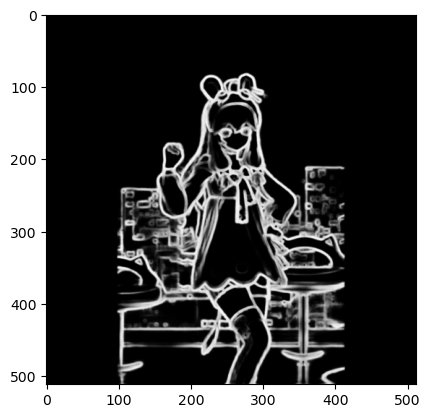

In [27]:
root_path = "/home/ubuntu/AI二次元/0319_jiaran_yao"

# hed图片位置
hed_img_path = os.path.join(root_path, "transfered_images")
file_list = os.listdir(hed_img_path)
img_num = len(file_list)
img_num = 100
hed_img_list = []
for i in range(img_num):
    filename = str(i+1) + ".png"
    file_path = os.path.join(hed_img_path, filename)
    hed_image = Image.open(file_path)
    hed_image = SquarePad()(hed_image)
    hed_image = F.resize(hed_image, size=(512,512))   
    hed_img_list.append(hed_image)
plt.imshow(hed_image)

## Generate random noise

In [28]:
height = 512              
width = 512 
batch_size = 1

noisy_img_list = []

for i in range(img_num):
    # Prep latents
    torch.manual_seed(32)
    latents = torch.randn(
      (batch_size, 4, height // 8, width // 8),
    )
    noisy_img_list.append(latents)
print(torch.allclose(noisy_img_list[0],noisy_img_list[5]))

True


# Run pipeline controlnet as a test

In [30]:
# Loading model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "gsdf/Counterfeit-V2.5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe = pipe.to("cuda")

  0%|          | 0/20 [00:00<?, ?it/s]

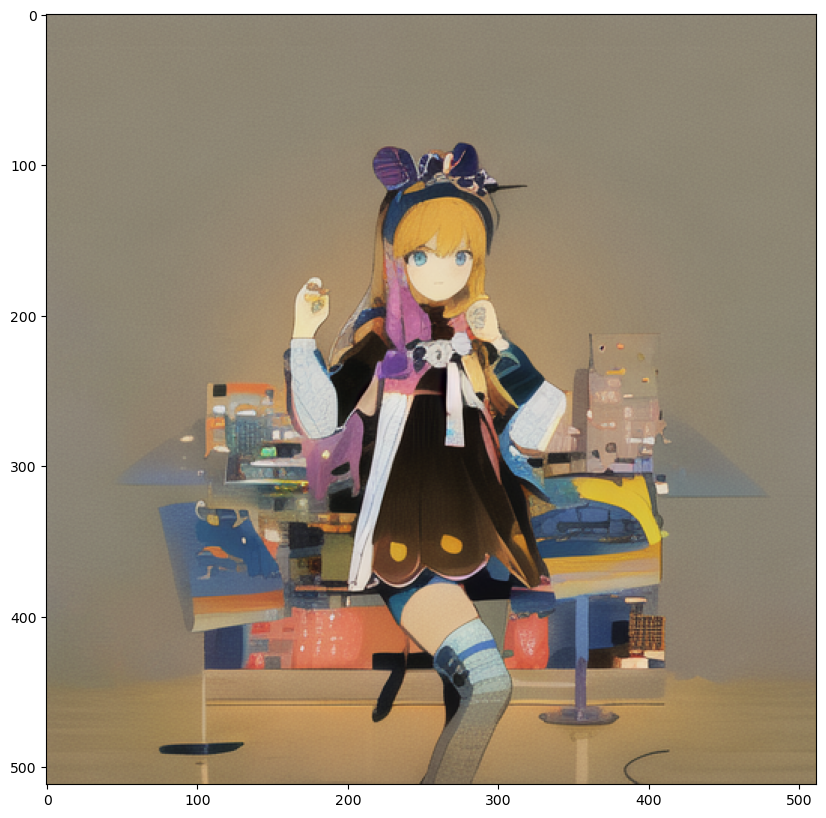

In [56]:
torch.manual_seed(32)
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output = pipe(
    prompt,
    hed_image,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
)
output
plt.figure(figsize=(10,10))
plt.imshow(output[0][0])

# 拆分Controlnet

https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/controlnet
https://github.com/huggingface/diffusers/blob/v0.14.0/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_controlnet.py#L574

In [58]:
# vae = AutoencoderKL.from_pretrained("gsdf/Counterfeit-V2.5", subfolder="vae")
# # tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
# # text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
# text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# # The UNet model for generating the latents.
# unet = UNet2DConditionModel.from_pretrained("gsdf/Counterfeit-V2.5", subfolder="unet")
# scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# # To the GPU we go!
# vae = vae.to(torch_device)
# text_encoder = text_encoder.to(torch_device)
# unet = unet.to(torch_device);
vae = pipe.vae
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet
scheduler = pipe.scheduler

## Encode input prompt

In [67]:
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
device = pipe._execution_device
num_images_per_prompt = 1
do_classifier_free_guidance = True
with torch.no_grad():
    prompt_embeds = pipe._encode_prompt(
        prompt,
        device = device,
        num_images_per_prompt = num_images_per_prompt,
        do_classifier_free_guidance = do_classifier_free_guidance,
        negative_prompt = negative_prompt,)
    print(prompt_embeds.shape)

torch.Size([2, 77, 768])


## Prepare condition image

In [87]:
with torch.no_grad():
    hed_image = pipe.prepare_image(
        hed_img_list[0],
        width,
        height,
        batch_size * num_images_per_prompt,
        num_images_per_prompt,
        device,
        pipe.controlnet.dtype,
        do_classifier_free_guidance = do_classifier_free_guidance,
    )
# plt.imshow(hed_image[0].permute(1,2,0).cpu().detach().numpy().astype(np.uint8)*255)
hed_image = torch.cat([hed_image] * 2)
# torch.Size([4, 3, 512, 512])

## Prepare timesteps

In [91]:
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = scheduler.timesteps

## Prepare latent variables

In [109]:
num_channels_latents = pipe.unet.in_channels
with torch.no_grad():
    latents = pipe.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        device,
        None,
        latents,
    )
print(latents.shape)

torch.Size([1, 4, 64, 64])


## Denoising loop

In [114]:
with torch.no_grad():
    num_warmup_steps = len(timesteps) - num_inference_steps * scheduler.order
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        down_block_res_samples, mid_block_res_sample = controlnet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=hed_image,
            return_dict=False,
        )

        down_block_res_samples = [
            down_block_res_sample * controlnet_conditioning_scale
            for down_block_res_sample in down_block_res_samples
        ]
        mid_block_res_sample *= controlnet_conditioning_scale

        # predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=cross_attention_kwargs,
            down_block_additional_residuals=down_block_res_samples,
            mid_block_additional_residual=mid_block_res_sample,
        ).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

RuntimeError: Input type (float) and bias type (c10::Half) should be the same